# Лабораторная работа №8: Парсинг сайтов и анализ текстовой информации

Данные: раздел кино на сайте https://irecommend.ru/catalog/list/10

**Пакеты, не из пятёрочки**

In [3]:
import re
import nltk
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import sleep
from random import randint
from pymystem3 import Mystem
from bs4 import BeautifulSoup
from wordcloud import WordCloud
from sklearn.manifold import TSNE
from nltk.corpus import stopwords
from sklearn.cluster import KMeans
from nltk.probability import FreqDist
from sklearn.decomposition import PCA
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [4]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rocks\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

**Загрузка наиболее свежих отзывов о фильмах**

In [11]:
count_pages = 30
movie_per_page = 20

movie_info = []

for page_num in range(0, count_pages):
    url = f'https://irecommend.ru/catalog/list/10?page={page_num}'
    r = requests.get(url)
    soup = BeautifulSoup(r.content, 'html.parser')
    
    movies = soup.find_all('div', class_='ProductTizer plate teaser-item')

    for movie in movies:
        title = movie.find('div', class_='title').text
        mean_rating = movie.find('span', class_='average-rating').find('span').text
        likes_count = movie.find('span', class_='RecommendRating-like').find('span').text
        dislikes_count = movie.find('span', class_='RecommendRating-dislike').find('span').text
        feedback_count = movie.find('span', class_='counter').text
        movie_info.append((title, mean_rating, likes_count, dislikes_count, feedback_count))

    print(f'{page_num+1}✓', end=' ')
    sleep(randint(7, 9))

if len(movie_info) == count_pages*movie_per_page:
    print('All elements are parsed')
    df = pd.DataFrame(movie_info, columns=['title', 'mean_rating', 'likes_count', 'dislikes_count', 'feedback_count'])
else:
    print('WTF??')

1✓ 2✓ 3✓ 4✓ 5✓ 6✓ 7✓ 8✓ 9✓ 10✓ 11✓ 12✓ 13✓ 14✓ 15✓ 16✓ 17✓ 18✓ 19✓ 20✓ 21✓ 22✓ 23✓ 24✓ 25✓ 26✓ 27✓ 28✓ 29✓ 30✓ All elements are parsed


In [12]:
df.head()

,title,mean_rating,likes_count,dislikes_count,feedback_count
0,Раневская (сериал),4.2,14,2,16
1,Будни роддома (2023),4.2,4,1,5
2,"Сериал ""Король и Шут""",4.1,57,10,67
3,Бывшие любимые,5,2,0,2
4,"Привидение (Призрак) / Ghost (1990, фильм)",5,43,0,43


**Первичный анализ**

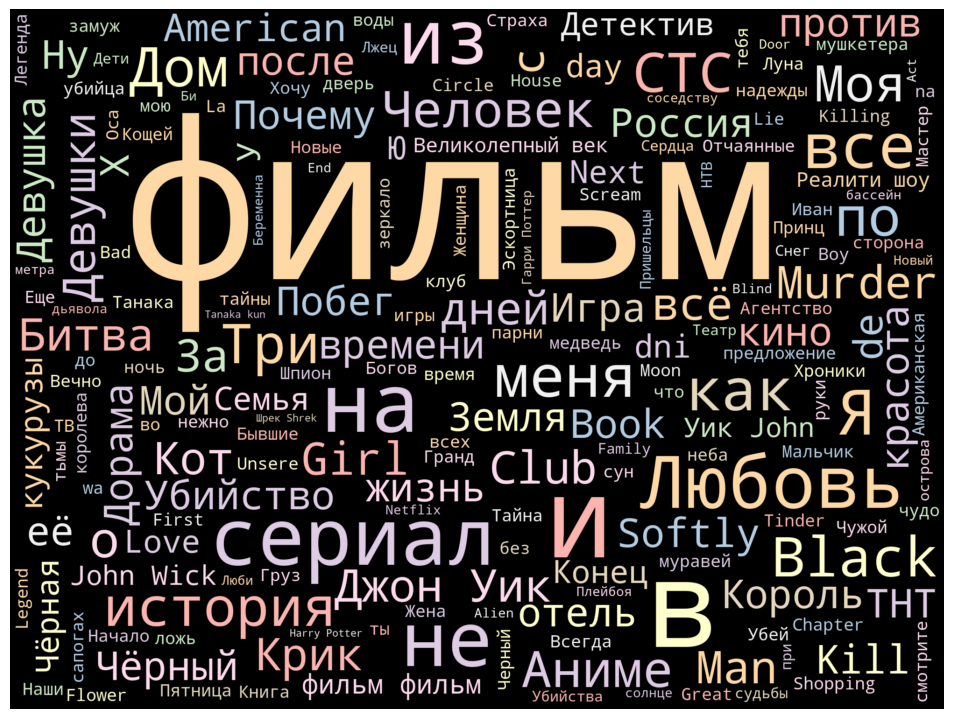

In [13]:
wordcloud = WordCloud(width=2000, height=1500, background_color='black',
                      colormap='Pastel1', min_font_size=15, margin=15).generate(' '.join(df['title']))

plt.figure(figsize=(15, 7), facecolor=None)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

Самым часто встречаещемся словом является фильм. Также видны слова сериал, аниме. Встречаются английские слова, обозначающие скорее всего название кино на языке оригинала. Избавимся от них и стоп слов

In [50]:
stop_words = stopwords.words("russian")
m = Mystem()

def clean_title_lemmatize(title):
    title = title.lower()
    title = re.sub(r'([a-z]+ [0-9]+|[a-z]+)', '', title) #уберём английские названия фильмов
    title = re.sub(r'[^\w\s]', '', title) #уберём не цифробуквенные значение и не пробелы
    words = word_tokenize(title)
    words = [word for word in words if word not in stop_words]
    title = ' '.join(words)
    lemmas = m.lemmatize(title)
    return ''.join(lemmas).replace('\n', '')

df = pd.DataFrame(movie_info, columns=['title', 'mean_rating', 'likes_count', 'dislikes_count', 'feedback_count'])
df['title'] = df['title'].apply(clean_title_lemmatize)

In [51]:
df.head()

,title,mean_rating,likes_count,dislikes_count,feedback_count
0,раневский сериал,4.2,14,2,16
1,будни роддом 2023,4.2,4,1,5
2,сериал король шут,4.1,57,10,67
3,бывший любимый,5,2,0,2
4,привидение призрак 1990 фильм,5,43,0,43


**Анализ после обработки**

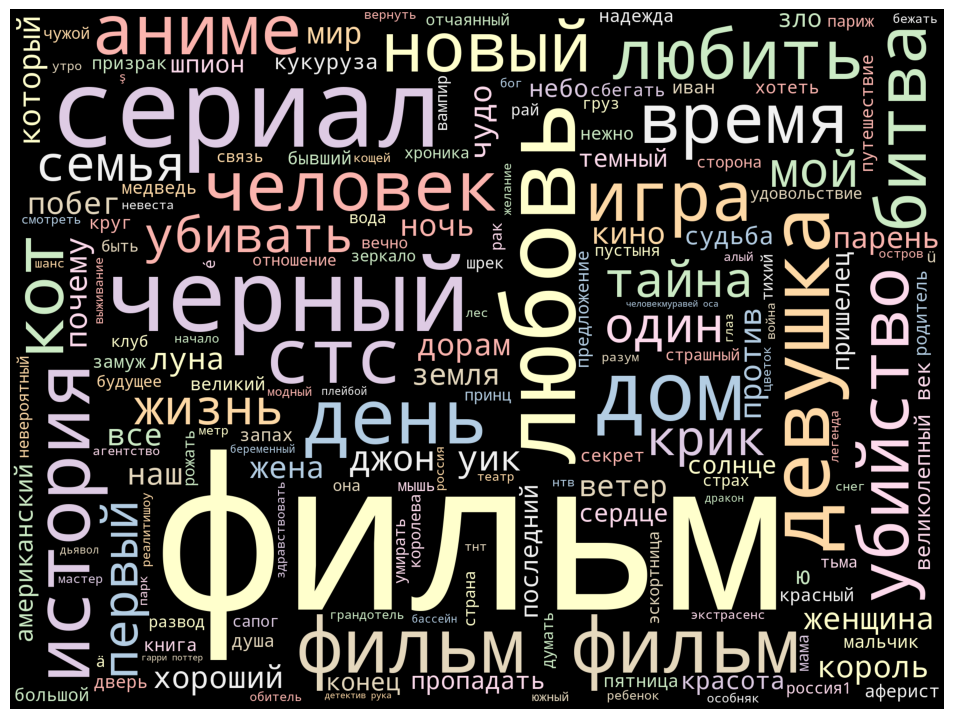

In [52]:
wordcloud = WordCloud(width=2000, height=1500, background_color='black',
                      colormap='Pastel1', min_font_size=15, margin=15).generate(' '.join(df['title']))

plt.figure(figsize=(15, 7), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

**Частотный анализ слов**

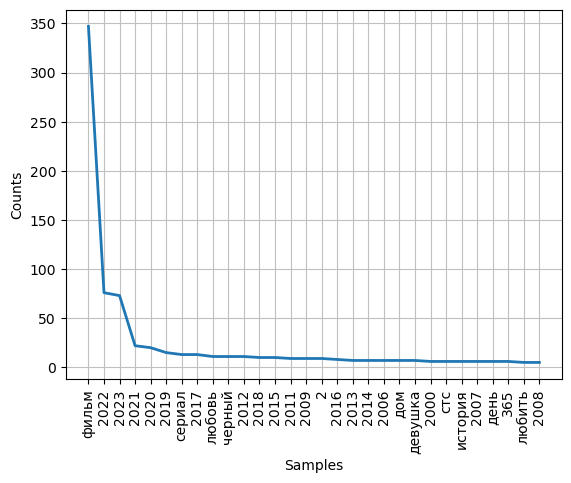

In [53]:
fdist = FreqDist()

for title in df['title']:
    for word in title.split():
        fdist[word] += 1

fdist.plot(30)
plt.show()

Как видно, при описании фильма часто указывают год фильма. Так как исходная статистика формируется из самых свежих отзывов, то и логично что чаще встречаются года ближе к текущей дате. Так же слово фильм является наиболее распространнём, в разы по сравнению с сериалом.

**Разделение с помощью TfidVectorizer и CountVectorizer**

In [54]:
titles = df['title']

tfidf_vectorizer = TfidfVectorizer()
tfidf_vectors = tfidf_vectorizer.fit_transform(df['title'])

n_clusters = 10
tfidf_kmeans = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=100, n_init=1)
tfidf_clusters = tfidf_kmeans.fit_predict(tfidf_vectors)

for i in range(n_clusters):
    print(f"Cluster {i+1}:")
    print(titles[tfidf_clusters == i])
    print()

Cluster 1:
518    новый ультрамен 2022 фильм
Name: title, dtype: object

Cluster 2:
29    убивать поксун 2023 фильм
Name: title, dtype: object

Cluster 3:
1                               будни роддом 2023
3                                  бывший любимый
4                   привидение призрак 1990 фильм
5                      маленький ложье 2022 фильм
6                брат супер марио кино 2023 фильм
                          ...                    
595                                  училка закон
596              срочно выходить замуж 2015 фильм
597                            часовой 2023 фильм
598    приходить ресторан ведьма южный корея 2021
599                 тридевятый царство 1970 фильм
Name: title, Length: 571, dtype: object

Cluster 4:
0                   раневский сериал
2                  сериал король шут
21              кафе куб сериал 2023
80                 фишер сериал 2023
141                    викинг сериал
197                      игра сериал
278              оффл

In [55]:
count_vectorizer = CountVectorizer()
count_vectors = count_vectorizer.fit_transform(titles)

count_kmeans = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=100, n_init=1)
count_clusters = count_kmeans.fit_predict(count_vectors)

for i in range(n_clusters):
    print(f"Cluster {i+1}:")
    print(titles[count_clusters == i])
    print()

Cluster 1:
30    рассказ служанка
Name: title, dtype: object

Cluster 2:
4                    привидение призрак 1990 фильм
11     иван васильевич менять профессия 1973 фильм
12                       побег шоушенка 1994 фильм
13                        фильм домовый 2019 фильм
27                            выкрутасы 2011 фильм
                          ...                     
584                           холм глаз 2006 фильм
588                   метр уровень небо 2010 фильм
591        великолепный век фильм фильм 2012 фильм
596               срочно выходить замуж 2015 фильм
599                  тридевятый царство 1970 фильм
Name: title, Length: 173, dtype: object

Cluster 3:
497    девушка соседство девушка особняк плейбой деву...
Name: title, dtype: object

Cluster 4:
20               кожа 2017 фильм
61               1922 2017 фильм
82          красный браслет 2017
89         джон уик 2 2017 фильм
146     обет молчание 2017 фильм
201     ловушка время 2017 фильм
216          балерин

Разбиение по 10 кластэрам, очевидно, отработало не совсем корректным образом, сформировав, например, с помощью CountVectorizer() кластеры по годам фильмов 2017;2020;2023;2022;остальная часть лет, которые встречаются явно реже;  
TfidfVectorizer() - сформировал кластеры по темам: фильмы, сериалы и остальные;  
Предлагается переопределить кластеры:  
TfidfVectorizer() - 3 кластера, удалим числа дабы повысить качество модели  
CountVectorizer() - 5 кластеров, удалим слова фильм и сериал дабы повысить качество модели  

Также зададим n_init = 10 чтобы несколько раз провести алгоритм KMeans и выбрать лучший результат

In [80]:
def clean_for_TF(title):
    return re.sub(r'[0-9]{4}', '', title)

titles_for_TF = df['title']
titles_for_TF = titles_for_TF.apply(clean_for_TF)
n_clusters = 3

tfidf_vectorizer = TfidfVectorizer()
tfidf_vectors = tfidf_vectorizer.fit_transform(titles_for_TF)

tfidf_kmeans = KMeans(n_clusters=n_clusters, init='random', max_iter=100, n_init=10)
tfidf_clusters = tfidf_kmeans.fit_predict(tfidf_vectors)

for i in range(n_clusters):
    print(f"Cluster {i+1}:")
    print(titles_for_TF[tfidf_clusters == i])
    print()

Cluster 1:
1                               будни роддом 
3                              бывший любимый
7                                подслушивать
10                            большой надежда
16                       книжный магазин блэк
                        ...                  
586               банановый рыба рыбкабананко
587                     видео коллекция асмра
592               реалитишоу обмен дом россия
595                              училка закон
598    приходить ресторан ведьма южный корея 
Name: title, Length: 246, dtype: object

Cluster 2:
4          привидение призрак  фильм
5             маленький ложье  фильм
6       брат супер марио кино  фильм
8      рядом реветь революция  фильм
9             все везде сразу  фильм
                   ...              
593                      ужин  фильм
594           решение уходить  фильм
596     срочно выходить замуж  фильм
597                   часовой  фильм
599        тридевятый царство  фильм
Name: title, Length: 341

In [85]:
def clean_for_CV(title):
    return re.sub(r'(фильм|сериал)', '', title)

titles_for_CV = df['title']
titles_for_CV = titles_for_CV.apply(clean_for_CV)
n_clusters = 5

count_vectorizer = CountVectorizer()
count_vectors = count_vectorizer.fit_transform(titles_for_CV)

count_kmeans = KMeans(n_clusters=n_clusters, init='random', max_iter=100, n_init=10)
count_clusters = count_kmeans.fit_predict(count_vectors)

for i in range(n_clusters):
    print(f"Cluster {i+1}:")
    print(titles_for_CV[count_clusters == i])
    print()

Cluster 1:
27                                       выкрутасы 2011 
185                                   область тьма 2011 
227                         девушка который видеть запах
228                               неприкасаемый 11 2011 
269                                      дом греза 2011 
324                          темный сторона бункер 2011 
402                              пропадать девушка 2011 
420                                      дом ветер 2011 
483                                  девушка поезд 2016 
497    девушка соседство девушка особняк плейбой деву...
513                                    слепой 블라인드 2011 
558                      девушка татуировка дракон 2011 
Name: title, dtype: object

Cluster 2:
5             маленький ложье 2022 
8      рядом реветь революция 2022 
9             все везде сразу 2022 
39               хотеть замуж 2022 
47           здоровый человек 2022 
                   ...             
549                     меган 2022 
551           

Получилось добится лучших результатов разбиения на разные группы

In [86]:
def make_cooccurrence_matrix(texts):
    # Зададим словарь и попарную частоту совместной встречаемости слов
    vocabulary = set(texts[0].split())
    for t in texts[1:]:
        vocabulary = vocabulary.union(set(t.split()))
    vocabulary=list(vocabulary)

    N = len(vocabulary)
  
    # Задаём cooccurrence matrix
    cooccurrence = np.zeros((N,N))
    for i in range(N):
        for j in range(i, N):
            if i == j:
                continue
        for t in texts:
            if vocabulary[i] in t.split() and vocabulary[j] in t.split():
                cooccurrence[i][j]+=1
                cooccurrence[j][i]+=1
    return cooccurrence, vocabulary

C:\Users\rocks\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 24320 (\N{CJK UNIFIED IDEOGRAPH-5F00}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\rocks\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 31471 (\N{CJK UNIFIED IDEOGRAPH-7AEF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\rocks\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 48660 (\N{HANGUL SYLLABLE BEUL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\rocks\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 46972 (\N{HANGUL SYLLABLE RA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\rocks\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 51064 (\N{HANGUL SYLLABLE IN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\roc

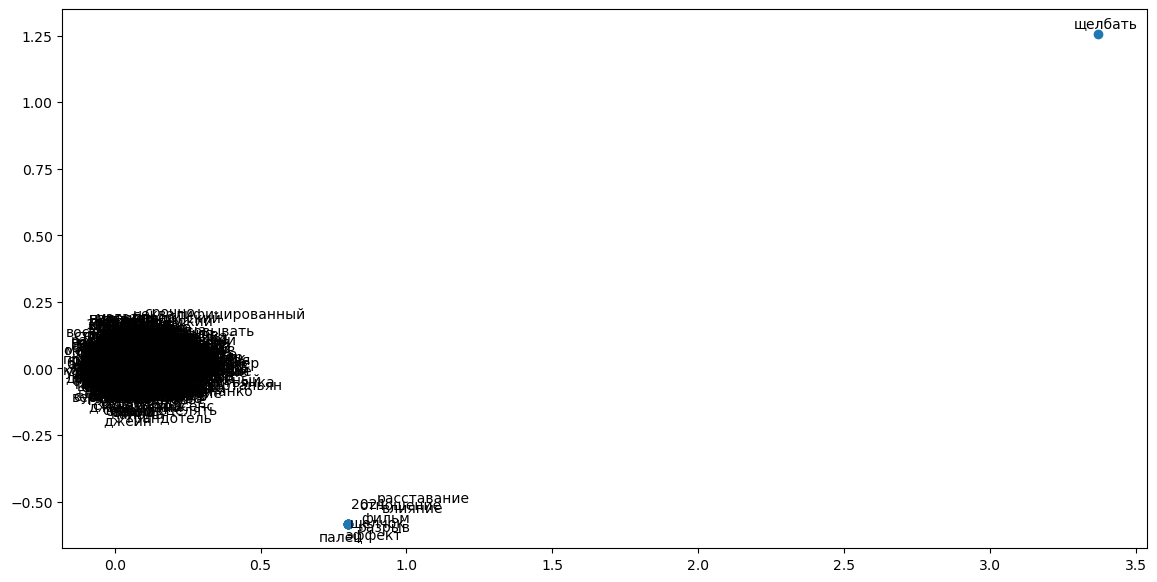

In [87]:
text_list = df['title'].tolist()

c, v = make_cooccurrence_matrix(text_list)

p = PCA(n_components=2)
pca = p.fit_transform(c)

plt.figure(figsize=(14,7))
ax = plt.gca()
for i, c in enumerate(pca):
    ax.annotate(text = v[i], xy = (c[0] + np.random.randn()/15, c[1]+ np.random.randn()/15))
plt.scatter(pca[:,0], pca[:,1])
plt.show()

C:\Users\rocks\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\rocks\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


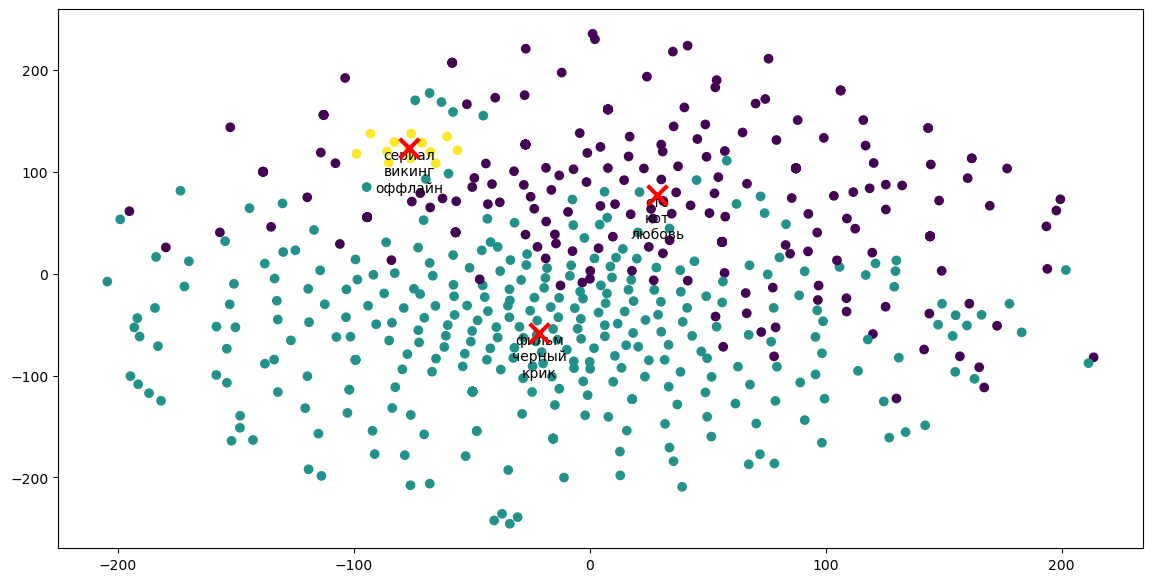

In [93]:
tsne = TSNE(n_components=2)
reduced_vectors = tsne.fit_transform(tfidf_vectors.toarray())

centroids = np.zeros((3, 2))
for i in range(3):
    centroids[i] = np.mean(reduced_vectors[tfidf_clusters == i], axis=0)

plt.figure(figsize=(14, 7))
plt.scatter(reduced_vectors[:, 0], reduced_vectors[:, 1], c=tfidf_clusters)
plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', s=200, linewidths=3, color='r', zorder=10)

for i in range(3):
    cluster_words = tfidf_vectors[tfidf_clusters == i].toarray().sum(axis=0)
    top_words_indices = cluster_words.argsort()[-3:][::-1]
    top_words = [tfidf_vectorizer.get_feature_names_out()[index] for index in top_words_indices]
    plt.annotate('\n'.join(top_words), (centroids[i, 0], centroids[i, 1]), ha='center', va='top')

plt.show()

In [97]:
df['mean_rating'] = df['mean_rating'].astype(float)

df['cluster'] = tfidf_clusters

title_count = df.groupby('cluster')['title'].count()
mean_rating = df.groupby('cluster')['mean_rating'].mean()
max_rating = df.groupby('cluster')['mean_rating'].max()
min_rating = df.groupby('cluster')['mean_rating'].min()
median_rating = df.groupby('cluster')['mean_rating'].median()

stats_df = pd.concat([title_count, mean_rating, max_rating, min_rating, median_rating], axis=1)
stats_df.columns = ['title_count', 'mean_rating', 'max_rating', 'min_rating', 'median_rating']

stats_df

,title_count,mean_rating,max_rating,min_rating,median_rating
cluster,,,,,
0,246,4.094715,5.0,1.3,4.3
1,341,3.947801,5.0,1.0,4.1
2,13,3.953846,4.8,3.0,4.0


C:\Users\rocks\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\rocks\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


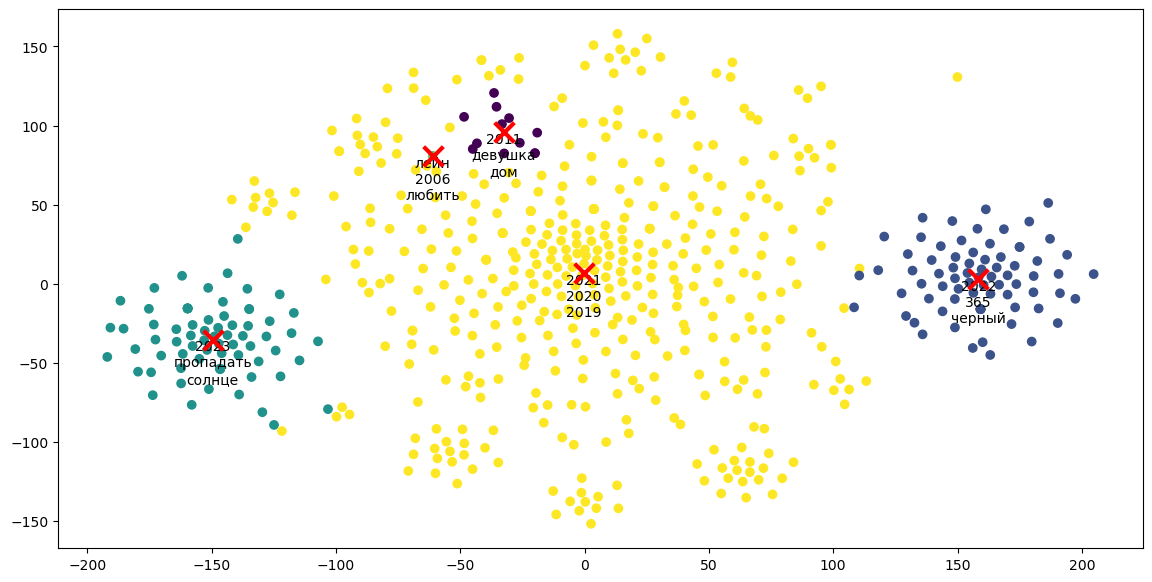

In [95]:
tsne = TSNE(n_components=2)
reduced_vectors = tsne.fit_transform(count_vectors.toarray())

centroids = np.zeros((5, 2))
for i in range(5):
    centroids[i] = np.mean(reduced_vectors[count_clusters == i], axis=0)

plt.figure(figsize=(14, 7))
plt.scatter(reduced_vectors[:, 0], reduced_vectors[:, 1], c=count_clusters)
plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', s=200, linewidths=3, color='r', zorder=10)

for i in range(5):
    cluster_words = count_vectors[count_clusters == i].toarray().sum(axis=0)
    top_words_indices = cluster_words.argsort()[-3:][::-1]
    top_words = [count_vectorizer.get_feature_names_out()[index] for index in top_words_indices]
    plt.annotate('\n'.join(top_words), (centroids[i, 0], centroids[i, 1]), ha='center', va='top')

plt.show()

In [98]:
df['cluster'] = count_clusters

title_count = df.groupby('cluster')['title'].count()
mean_rating = df.groupby('cluster')['mean_rating'].mean()
max_rating = df.groupby('cluster')['mean_rating'].max()
min_rating = df.groupby('cluster')['mean_rating'].min()
median_rating = df.groupby('cluster')['mean_rating'].median()

stats_df = pd.concat([title_count, mean_rating, max_rating, min_rating, median_rating], axis=1)
stats_df.columns = ['title_count', 'mean_rating', 'max_rating', 'min_rating', 'median_rating']

stats_df

,title_count,mean_rating,max_rating,min_rating,median_rating
cluster,,,,,
0,12,4.300000,4.9,3.0,4.45
1,75,3.640000,5.0,1.0,3.80
2,72,3.762500,5.0,1.5,3.95
3,1,3.400000,3.4,3.4,3.40
4,440,4.104545,5.0,1.0,4.30
